# Competição DSA de Machine Learning
# Edição Setembro/2019

##### Referencias
- https://www.kaggle.com/c/career-con-2019
- https://www.kaggle.com/artgor/where-do-the-robots-drive
- https://www.kaggle.com/gpreda/robots-need-help
- https://www.kaggle.com/friedchips/the-missing-link
- https://www.kaggle.com/c/career-con-2019/discussion/87239

# Importando as bibliotecas que serão utilizadas neste projeto

In [1]:
# Pacotes basicos
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import imblearn
import math

# Metricas e Graficos
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from seaborn import countplot, lineplot, barplot
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import kurtosis, skew

# Modelos
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Tratamento de warning e exibição no Jupyter
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)

# Matplot 
import matplotlib.pyplot as plt
import matplotlib.style as style 
%matplotlib inline
style.use('ggplot')

# Outras libs
import pickle
import os
from time import time
import gc
gc.enable()

Using TensorFlow backend.


# Carregando os dados

In [2]:
treino = pd.read_csv('../input/competicao-dsa-machine-learning-sep-2019/X_treino.csv')
teste = pd.read_csv('../input/competicao-dsa-machine-learning-sep-2019/X_teste.csv')
target = pd.read_csv('../input/competicao-dsa-machine-learning-sep-2019/y_treino.csv')
sub = pd.read_csv('../input/competicao-dsa-machine-learning-sep-2019/sample_submission.csv')

# Análise Exploratória (EAD)

In [3]:
# Primeiros registros do dataset de treino
treino.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
# Primeiros registros do dataset de teste
teste.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In [5]:
# Primeiros registros do dataset target
target.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [6]:
# Analise estatística do dataset de treino
treino.describe().T

,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


In [7]:
# Analise estatística do dataset de teste
teste.describe().T

,count,mean,std,min,25%,50%,75%,max
series_id,488448.0,1907.500000,1101.585403,0.00000,953.750000,1907.500000,2861.250000,3815.00000
measurement_number,488448.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,488448.0,0.031996,0.671977,-0.98972,-0.648130,0.132910,0.575270,0.98932
orientation_Y,488448.0,0.120651,0.714522,-0.98981,-0.744503,0.397860,0.803600,0.98894
orientation_Z,488448.0,0.018735,0.108481,-0.15468,-0.112660,0.057271,0.124770,0.15425
orientation_W,488448.0,0.004024,0.100957,-0.15627,-0.098435,0.022654,0.083706,0.15251
angular_velocity_X,488448.0,0.000401,0.114485,-2.40330,-0.037396,0.001107,0.037827,3.39660
angular_velocity_Y,488448.0,0.013669,0.089440,-1.19300,-0.029865,0.007276,0.051112,1.15070
angular_velocity_Z,488448.0,-0.036101,0.233791,-1.45820,-0.089842,-0.008911,0.057876,0.96028
linear_acceleration_X,488448.0,0.125433,1.832639,-35.04000,-0.486233,0.112490,0.727250,36.62800


In [8]:
# Analise estatística do dataset target
target.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


In [9]:
# Cada serie tem 128 medidas
len(treino.measurement_number.value_counts())

128

In [10]:
# Verificar se existem dados nulos no dataset de treino
treino.isnull().values.any() 

False

In [11]:
# Verificar se existem dados nulos no dataset de teste
teste.isnull().values.any() 

False

In [12]:
# Existem 6 series a mais no dataset de teste
(teste.shape[0] - treino.shape[0]) / 128

6.0

In [13]:
# Existe 73 grupos unicos no dataset target 
target['group_id'].nunique()

73

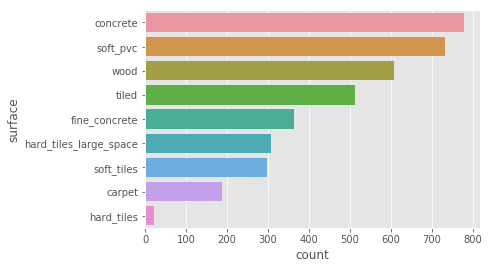

In [14]:
# Visualizando todos os tipos de superfície do dataset target, ordenado pela quantidade de registros
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

## Visualização dos Grupos

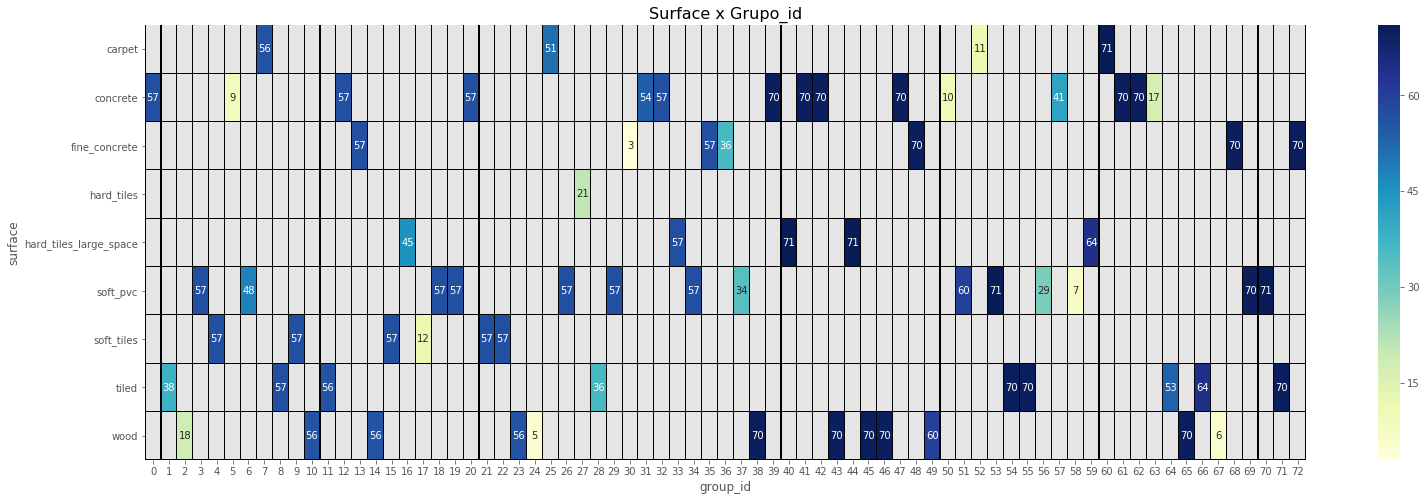

In [15]:
# Visualizando a distribuição das features: group_id e surface
# Créditos: https://www.kaggle.com/gpreda/robots-need-help
fig, ax = plt.subplots(1,1,figsize=(26,8))
grp = pd.DataFrame(target.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
piv = grp.pivot(index='surface', columns='group_id', values='series_id')
grafico = sns.heatmap(piv, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
grafico.set_title('Surface x Grupo_id', size=16)
plt.show()

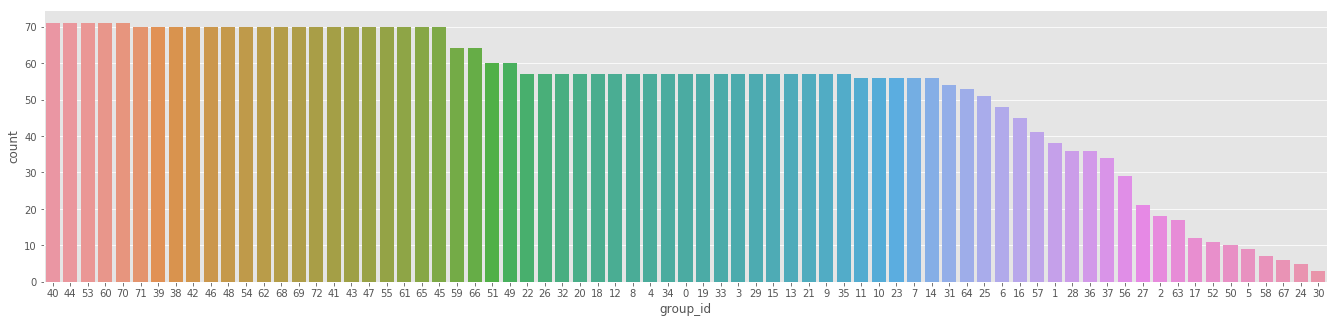

In [16]:
# Grafico de contador de numero de registros por group_id, ordenado
plt.figure(figsize=(23,5)) 
countplot(x="group_id", data=target, order=target['group_id'].value_counts().index)
plt.show()

## Visualização das Series

In [17]:
series_dict = {}
for series in (treino['series_id'].unique()):
    series_dict[series] = treino[treino['series_id'] == series]  

In [18]:
def plot_series(series_id):
    plt.figure(figsize=(28, 16))
    print(target[target['series_id'] == series_id]['surface'].values[0].title())
    for i, col in enumerate(series_dict[series_id].columns[3:]):
        if col.startswith("o"):
            color = 'red'
        elif col.startswith("a"):
            color = 'green'
        else:
            color = 'blue'
        if i >= 7:
            i+=1
        plt.subplot(3, 4, i + 1)
        plt.plot(series_dict[series_id][col], color=color, linewidth=3)
        plt.title(col)

Fine_Concrete


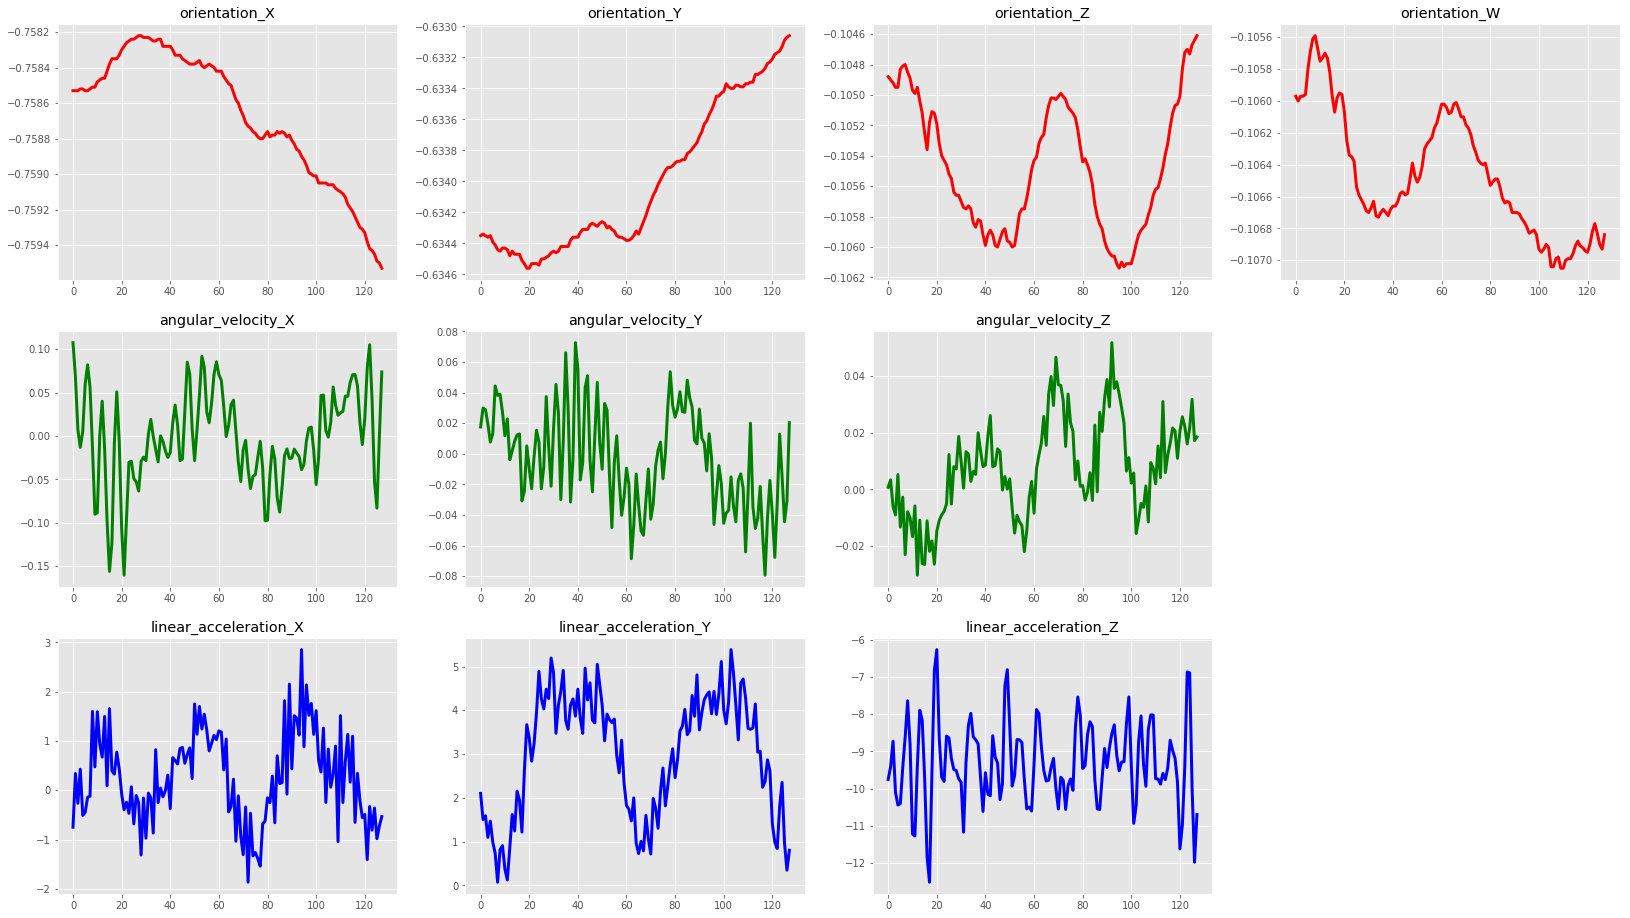

In [19]:
# Visualizando a serie de código 0
id_series = 0
plot_series(id_series)

## Correlação

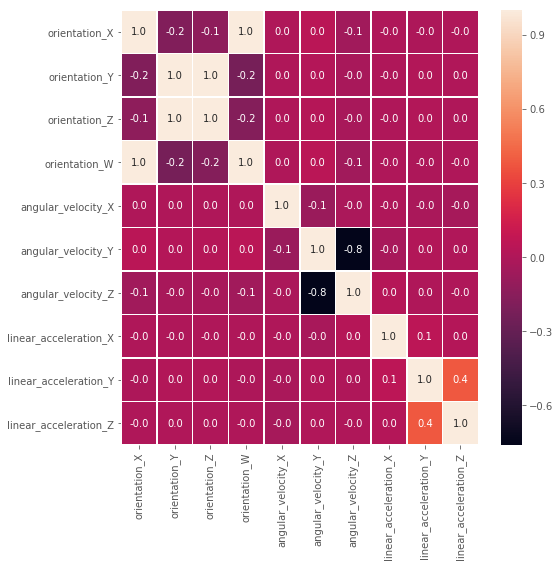

In [20]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(treino.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

## Gráficos de Distribuição

In [21]:
def plot_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

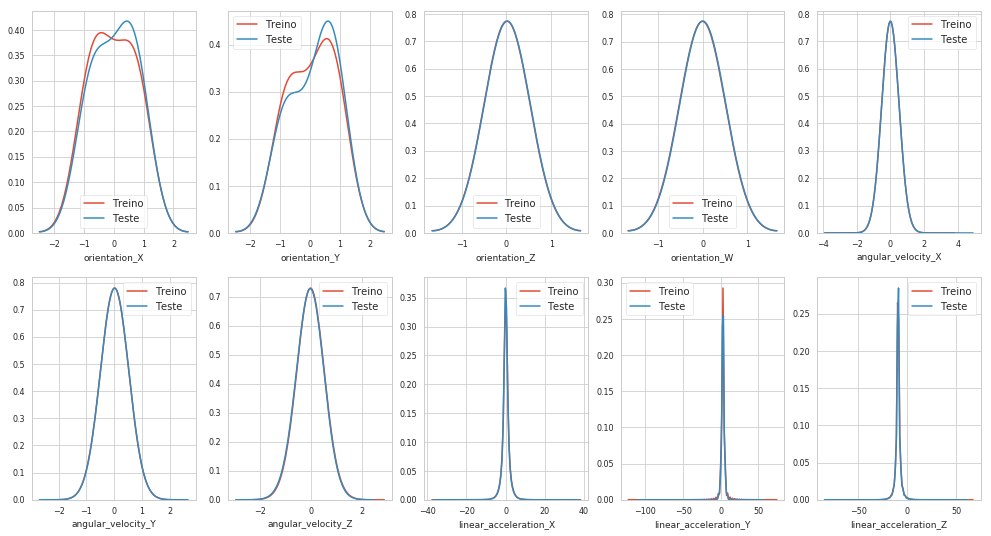

In [22]:
# Gráfico de distribuição por dataset (treino x teste)
features = treino.columns.values[3:]
plot_distribution(treino, teste, 'Treino', 'Teste', features)

In [23]:
def plot_classes_distribution(classes, tt, features,a=5,b=2):
    i = 0
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for cl in classes:
            ttc = tt[tt['surface']==cl]
            sns.kdeplot(ttc[feature], bw=0.5,label=cl)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

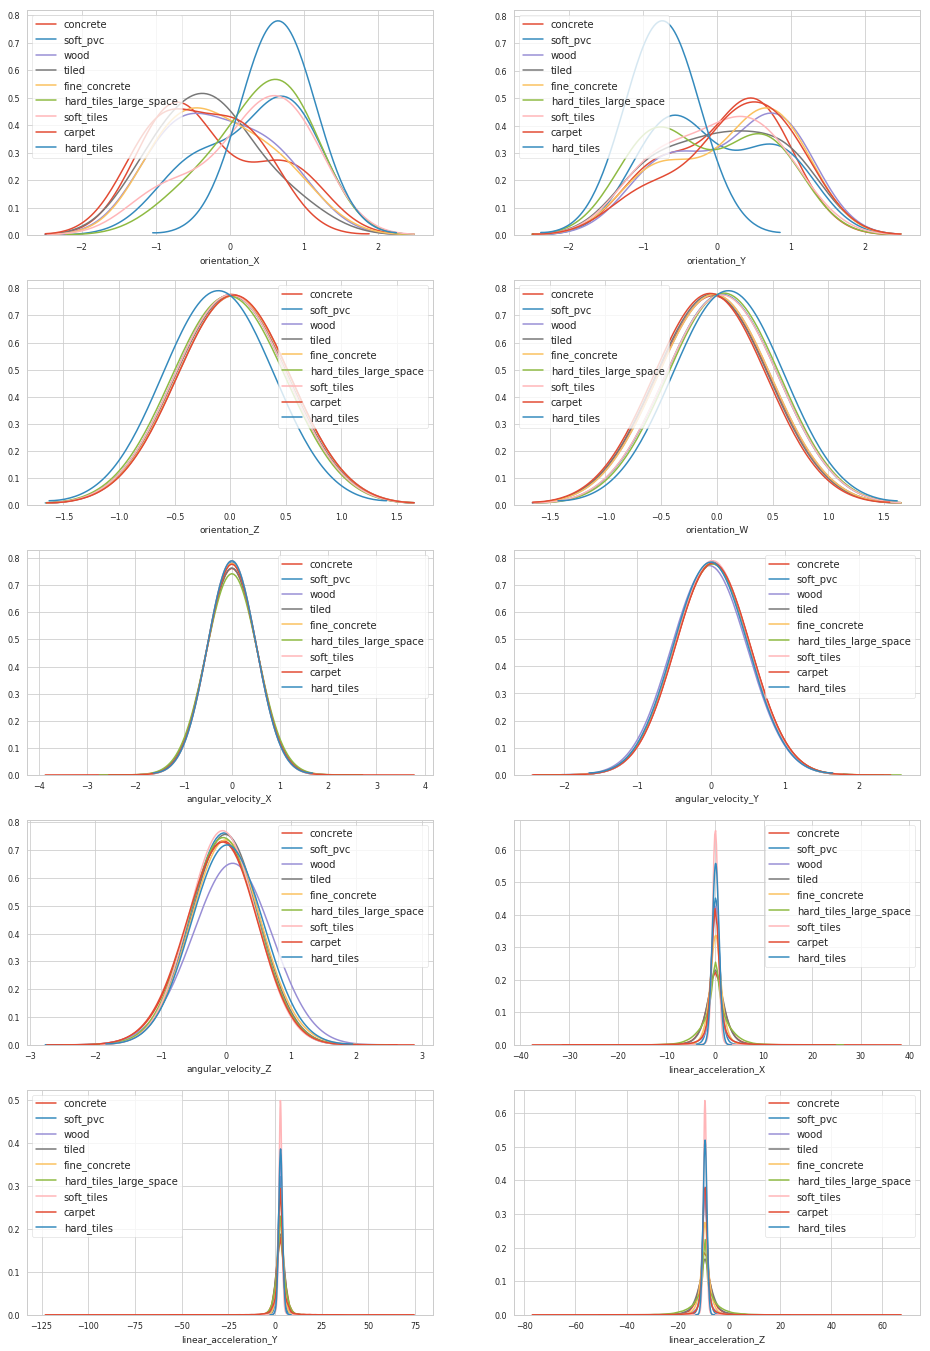

In [24]:
# Gráfico de distribuição por classe
classes = (target['surface'].value_counts()).index
aux = treino.merge(target, on='series_id', how='inner')
plot_classes_distribution(classes, aux, features)

# Feature Enginnering

### Criando funções auxiliares para definição de novas features

In [25]:
# Funcao para converter Quaternions para Angulos de Euler
def quaternion_to_euler(x, y, z, w):

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

# Funções para criação de features estatísticas
def _kurtosis(x):
    return kurtosis(x)

def skewness(x):
    return skew(x)

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    
    xn_i1 = x[0:len(x)-2]  
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(np.heaviside(-xn*xn_i2,0))

In [26]:
# Função para criação de novas features
def fn_features_01(df):
    df['totl_anglr_vel'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)** 0.5
    df['totl_linr_acc'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    df['totl_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    df['acc_vs_vel'] = df['totl_linr_acc'] / df['totl_anglr_vel']
    df['norm_quat'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2 + df['orientation_W']**2)
    df['mod_quat'] = (df['norm_quat'])**0.5
    df['norm_X'] = df['orientation_X'] / df['mod_quat']
    df['norm_Y'] = df['orientation_Y'] / df['mod_quat']
    df['norm_Z'] = df['orientation_Z'] / df['mod_quat']
    df['norm_W'] = df['orientation_W'] / df['mod_quat']
    
    x, y, z, w = df['norm_X'].tolist(), df['norm_Y'].tolist(), df['norm_Z'].tolist(), df['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    df['euler_x'] = nx
    df['euler_y'] = ny
    df['euler_z'] = nz

    return df

In [27]:
# Função para criação de novas features, agrupando por series_id
def fn_features_02(data):
    df = pd.DataFrame()
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number', 'orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
        
        # Advanced Features
        df[col + '_skew'] = data.groupby(['series_id'])[col].skew()
        df[col + '_mad'] = data.groupby(['series_id'])[col].mad()
        df[col + '_q25'] = data.groupby(['series_id'])[col].quantile(0.25)
        df[col + '_q75'] = data.groupby(['series_id'])[col].quantile(0.75)
        df[col + '_q95'] = data.groupby(['series_id'])[col].quantile(0.95)
        df[col + '_iqr'] = df[col + '_q75'] - df[col + '_q25']
        df[col + '_SSC'] = data.groupby(['series_id'])[col].apply(SSC) 
        df[col + '_skewness'] = data.groupby(['series_id'])[col].apply(skewness)
        df[col + '_wave_lenght'] = data.groupby(['series_id'])[col].apply(wave_length)
        df[col + '_norm_entropy'] = data.groupby(['series_id'])[col].apply(norm_entropy)
        df[col + '_SRAV'] = data.groupby(['series_id'])[col].apply(SRAV)
        df[col + '_kurtosis'] = data.groupby(['series_id'])[col].apply(_kurtosis) 
        df[col + '_zero_crossing'] = data.groupby(['series_id'])[col].apply(zero_crossing) 

    return df
    

In [28]:
# Aplicando novas features nos datasets de treino e teste
treino = fn_features_01(treino)
teste = fn_features_01(teste)
treino.shape, teste.shape

((487680, 26), (488448, 26))

In [29]:
# Aplicando novas features nos datasets de treino e teste
# Esta celula demora um pouco para concluir (cerca de 10min)
treino = fn_features_02(treino)
teste = fn_features_02(teste)
treino.shape, teste.shape

((3810, 475), (3816, 475))

In [30]:
# Visualizando os primeiros registros do dataset de treino com as novas features
treino.head()

,angular_velocity_X_mean,angular_velocity_X_median,angular_velocity_X_max,angular_velocity_X_min,angular_velocity_X_std,angular_velocity_X_range,angular_velocity_X_maxtoMin,angular_velocity_X_mean_abs_chg,angular_velocity_X_mean_change_of_abs_change,angular_velocity_X_abs_max,angular_velocity_X_abs_min,angular_velocity_X_abs_avg,angular_velocity_X_skew,angular_velocity_X_mad,angular_velocity_X_q25,angular_velocity_X_q75,angular_velocity_X_q95,angular_velocity_X_iqr,angular_velocity_X_SSC,angular_velocity_X_skewness,angular_velocity_X_wave_lenght,angular_velocity_X_norm_entropy,angular_velocity_X_SRAV,angular_velocity_X_kurtosis,angular_velocity_X_zero_crossing,angular_velocity_Y_mean,angular_velocity_Y_median,angular_velocity_Y_max,angular_velocity_Y_min,angular_velocity_Y_std,angular_velocity_Y_range,angular_velocity_Y_maxtoMin,angular_velocity_Y_mean_abs_chg,angular_velocity_Y_mean_change_of_abs_change,angular_velocity_Y_abs_max,angular_velocity_Y_abs_min,angular_velocity_Y_abs_avg,angular_velocity_Y_skew,angular_velocity_Y_mad,angular_velocity_Y_q25,angular_velocity_Y_q75,angular_velocity_Y_q95,angular_velocity_Y_iqr,angular_velocity_Y_SSC,angular_velocity_Y_skewness,angular_velocity_Y_wave_lenght,angular_velocity_Y_norm_entropy,angular_velocity_Y_SRAV,angular_velocity_Y_kurtosis,angular_velocity_Y_zero_crossing,angular_velocity_Z_mean,angular_velocity_Z_median,angular_velocity_Z_max,angular_velocity_Z_min,angular_velocity_Z_std,angular_velocity_Z_range,angular_velocity_Z_maxtoMin,angular_velocity_Z_mean_abs_chg,angular_velocity_Z_mean_change_of_abs_change,angular_velocity_Z_abs_max,angular_velocity_Z_abs_min,angular_velocity_Z_abs_avg,angular_velocity_Z_skew,angular_velocity_Z_mad,angular_velocity_Z_q25,angular_velocity_Z_q75,angular_velocity_Z_q95,angular_velocity_Z_iqr,angular_velocity_Z_SSC,angular_velocity_Z_skewness,angular_velocity_Z_wave_lenght,angular_velocity_Z_norm_entropy,angular_velocity_Z_SRAV,angular_velocity_Z_kurtosis,angular_velocity_Z_zero_crossing,linear_acceleration_X_mean,linear_acceleration_X_median,linear_acceleration_X_max,linear_acceleration_X_min,linear_acceleration_X_std,linear_acceleration_X_range,linear_acceleration_X_maxtoMin,linear_acceleration_X_mean_abs_chg,linear_acceleration_X_mean_change_of_abs_change,linear_acceleration_X_abs_max,linear_acceleration_X_abs_min,linear_acceleration_X_abs_avg,linear_acceleration_X_skew,linear_acceleration_X_mad,linear_acceleration_X_q25,linear_acceleration_X_q75,linear_acceleration_X_q95,linear_acceleration_X_iqr,linear_acceleration_X_SSC,linear_acceleration_X_skewness,linear_acceleration_X_wave_lenght,linear_acceleration_X_norm_entropy,linear_acceleration_X_SRAV,linear_acceleration_X_kurtosis,linear_acceleration_X_zero_crossing,linear_acceleration_Y_mean,linear_acceleration_Y_median,linear_acceleration_Y_max,linear_acceleration_Y_min,linear_acceleration_Y_std,linear_acceleration_Y_range,linear_acceleration_Y_maxtoMin,linear_acceleration_Y_mean_abs_chg,linear_acceleration_Y_mean_change_of_abs_change,linear_acceleration_Y_abs_max,linear_acceleration_Y_abs_min,linear_acceleration_Y_abs_avg,linear_acceleration_Y_skew,linear_acceleration_Y_mad,linear_acceleration_Y_q25,linear_acceleration_Y_q75,linear_acceleration_Y_q95,linear_acceleration_Y_iqr,linear_acceleration_Y_SSC,linear_acceleration_Y_skewness,linear_acceleration_Y_wave_lenght,linear_acceleration_Y_norm_entropy,linear_acceleration_Y_SRAV,linear_acceleration_Y_kurtosis,linear_acceleration_Y_zero_crossing,linear_acceleration_Z_mean,linear_acceleration_Z_median,linear_acceleration_Z_max,linear_acceleration_Z_min,linear_acceleration_Z_std,linear_acceleration_Z_range,linear_acceleration_Z_maxtoMin,linear_acceleration_Z_mean_abs_chg,linear_acceleration_Z_mean_change_of_abs_change,linear_acceleration_Z_abs_max,linear_acceleration_Z_abs_min,linear_acceleration_Z_abs_avg,linear_acceleration_Z_skew,linear_acceleration_Z_mad,linear_acceleration_Z_q25,linear_acceleration_Z_q75,linear_acceleration_Z_q95,linear_accel

In [31]:
# Preenchendo os valores NA e inf com zero
# Acontece após a criação das novas variáveis estatísticas
treino.fillna(0,inplace=True)
treino.replace(-np.inf,0,inplace=True)
treino.replace(np.inf,0,inplace=True)

teste.fillna(0,inplace=True)
teste.replace(-np.inf,0,inplace=True)
teste.replace(np.inf,0,inplace=True)

In [32]:
# Transformando a feature 'surface' de string para numérico
le = preprocessing.LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

# Criação e Validação dos Modelos de Machine Learning

In [33]:
# Utilizando o método StratifiedKFold para realizar os grupos de treinamento
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)

In [34]:
previsao = np.zeros((teste.shape[0],9))
real = np.zeros((treino.shape[0]))
score = 0

In [35]:
# Execução da criação e treinamento do modelo
# Utilização do algoritmo RANDOM FOREST CLASSIFIER

for times, (trn_idx, val_idx) in enumerate(folds.split(treino.values, target['surface'].values)):
    rf = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    rf.fit(treino.iloc[trn_idx], target['surface'][trn_idx])
    real[val_idx] = rf.predict(treino.iloc[val_idx])
    previsao += rf.predict_proba(teste) / folds.n_splits
    score += rf.score(treino.iloc[val_idx], target['surface'][val_idx])
    print("Fold: {} score: {}".format(times, rf.score(treino.iloc[val_idx], target['surface'][val_idx])))
    gc.collect()

Fold: 0 score: 0.8987012987012987
Fold: 1 score: 0.9166666666666666
Fold: 2 score: 0.9321148825065274
Fold: 3 score: 0.900523560209424
Fold: 4 score: 0.9212598425196851
Fold: 5 score: 0.9133858267716536
Fold: 6 score: 0.9291338582677166
Fold: 7 score: 0.9050131926121372
Fold: 8 score: 0.9047619047619048
Fold: 9 score: 0.9202127659574468


In [36]:
print('Acuracia Media: ', score / folds.n_splits)

Acuracia Media:  0.9141773798974461


In [37]:
confusion_matrix(real, target['surface'])

array([[162,   3,   0,   0,   4,   1,   0,   2,   0],
       [ 14, 712,  15,   0,  11,  15,   5,  21,  14],
       [  0,   4, 313,   0,   4,   3,   0,   1,   3],
       [  0,   0,   0,  12,   0,   0,   0,   0,   0],
       [  0,   9,   0,   0, 283,   4,   0,   3,   1],
       [  3,  15,   6,   0,   1, 694,   2,   6,  18],
       [  1,  12,   2,   2,   0,   5, 284,   5,   1],
       [  1,   3,   4,   0,   0,   3,   0, 468,  15],
       [  8,  21,  23,   7,   5,   7,   6,   8, 555]])

# Submissão Kaggle

In [38]:
sub['surface'] = le.inverse_transform(previsao.argmax(axis=1))
#sub.to_csv('submission_rf.csv', index=False)
sub.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


### Gerando submissão usando link entre dataset de treino e teste
##### Créditos: https://www.kaggle.com/friedchips/the-missing-link

In [39]:
# Carregando novamente os datasets
tt_treino = pd.read_csv('../input/competicao-dsa-machine-learning-sep-2019/X_treino.csv')
tt_teste = pd.read_csv('../input/competicao-dsa-machine-learning-sep-2019/X_teste.csv')
tt_y_treino = pd.read_csv('../input/competicao-dsa-machine-learning-sep-2019/y_treino.csv')
ss = pd.read_csv('../input/competicao-dsa-machine-learning-sep-2019/sample_submission.csv')

In [40]:
# Concatenando os datasets de treino e teste
full = pd.concat([tt_treino, tt_teste])
full = full.iloc[:,3:].values.reshape(-1,128,10)

In [41]:
# Funções para calcular a distancia entre as amostras de dados
# O objetivo é identificar links entre os datasets de treino e teste
# Caso exista relações, estas serão utilizadas para avaliação no Kaggle
def sq_dist(a,b):
    return np.sum((a-b)**2, axis=1)

def find_run_edges(data, edge):
    if edge == 'left':
        border1 = 0
        border2 = -1
    elif edge == 'right':
        border1 = -1
        border2 = 0
    else:
        return False
    
    edge_list = []
    linked_list = []
    
    for i in range(len(data)):
        dist_list = sq_dist(data[i, border1, :4], data[:, border2, :4])
        min_dist = np.min(dist_list)
        closest_i   = np.argmin(dist_list)
        if closest_i == i:
            closest_i = np.argsort(dist_list)[1]
        dist_list = sq_dist(data[closest_i, border2, :4], data[:, border1, :4])
        rev_dist = np.min(dist_list)
        closest_rev = np.argmin(dist_list)
        if closest_rev == closest_i:
            closest_rev = np.argsort(dist_list)[1]
        if (i != closest_rev):
            edge_list.append(i)
        else:
            linked_list.append([i, closest_i, min_dist])
            
    return edge_list, linked_list

def find_runs(data, left_edges, right_edges):
    data_runs = []

    for start_point in left_edges:
        i = start_point
        run_list = [i]
        while i not in right_edges:
            tmp = np.argmin(sq_dist(data[i, -1, :4], data[:, 0, :4]))
            if tmp == i: # self-linked sample
                tmp = np.argsort(sq_dist(data[i, -1, :4], data[:, 0, :4]))[1]
            i = tmp
            run_list.append(i)
        data_runs.append(np.array(run_list))
    
    return data_runs

In [42]:
# Procurando por link entre os dados
train_left_edges, train_left_linked  = find_run_edges(full, edge='left')
train_right_edges, train_right_linked = find_run_edges(full, edge='right')
train_runs = find_runs(full, train_left_edges, train_right_edges)
print('Found', len(train_left_edges), 'left edges and', len(train_right_edges), 'right edges.')

Found 151 left edges and 151 right edges.


In [43]:
ss['surface'] = ''
df_surface = ''

for i in range(151):
    x = train_runs[i]
    x = np.sort(x)
    if x[0]<3810:
        df_surface = tt_y_treino['surface'][x[0]]
        for j in range(len(train_runs[i])):
            if train_runs[i][j]-3810>-1:
                ss['surface'][train_runs[i][j]-3810] = df_surface

In [44]:
ss.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,
3,3,fine_concrete
4,4,soft_tiles


### Gerando a melhor submissão para o Kaggle

In [45]:
y_train_runs = ss.copy()

sub_final = {}
for i in range(0, sub.shape[0]):
    sub_final.update({sub.iloc[i]['series_id'] : sub.iloc[i]['surface'] })
    
y_train_runs.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,
3,3,fine_concrete
4,4,soft_tiles


In [46]:
resultado = []
for i in range(0, y_train_runs.shape[0]):
    if (y_train_runs.surface[i] == ''):
        resultado.append(sub_final[i])
    else:
        resultado.append(y_train_runs.surface[i])
        
y_train_runs['surface'] = resultado
y_train_runs.to_csv('best_submission_rf.csv', index=False)
y_train_runs.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,fine_concrete
4,4,soft_tiles


In [47]:
y_train_runs.surface.value_counts()

concrete                  777
soft_pvc                  597
wood                      569
fine_concrete             483
hard_tiles_large_space    427
soft_tiles                412
carpet                    225
tiled                     218
hard_tiles                108
Name: surface, dtype: int64

In [48]:
y_train_runs.surface.value_counts() / y_train_runs.shape[0]

concrete                  0.203616
soft_pvc                  0.156447
wood                      0.149109
fine_concrete             0.126572
hard_tiles_large_space    0.111897
soft_tiles                0.107966
carpet                    0.058962
tiled                     0.057128
hard_tiles                0.028302
Name: surface, dtype: float64